## Based on kaggle.py


In [28]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import kornia.augmentation as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import shutil


In [29]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
train_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/train.csv')
test_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/test.csv')
base_path = 'C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot'

<Axes: xlabel='label'>

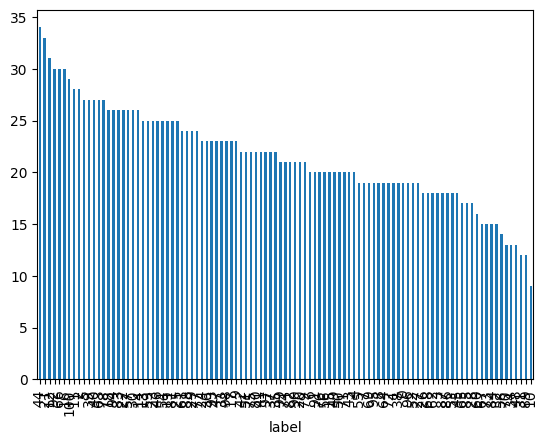

In [ ]:
train_df['label'].value_counts().plot(kind='bar')

## Removing Useless Data

# Removing 2451, 47


In [31]:
# shape_groups = defaultdict(list)

# for filename in os.listdir(base_path):
#     if filename.endswith('.npy'):
#         file_path = os.path.join(base_path, filename)
#         try:
#             data = np.load(file_path)
#             shape_groups[data.shape].append(filename)
#         except Exception as e:
#             print(f"⚠️ Failed to load {filename}: {e}")

# # Display the grouped shapes
# print("📊 SHAPE GROUPS FOUND:")
# for shape, files in shape_groups.items():
#     print(f"\nShape {shape} | Total: {len(files)}")
#     for f in files:
#         print(f" - {f}")

In [32]:
# # Create a trash bin folder inside 'ot'
# trash_folder = os.path.join(base_path, 'trash_bin')
# os.makedirs(trash_folder, exist_ok=True)

# # Step 1: Group all files by shape
# shape_groups = defaultdict(list)

# for filename in os.listdir(base_path):
#     if filename.endswith('.npy'):
#         file_path = os.path.join(base_path, filename)
#         try:
#             data = np.load(file_path)
#             shape_groups[data.shape].append(filename)
#         except Exception as e:
#             print(f"⚠️ Failed to load {filename}: {e}")

# # Step 2: Target the bad shape
# bad_shape = (128, 57, 125)

# # Step 3: Move the files to trash
# for filename in shape_groups.get(bad_shape, []):
#     src = os.path.join(base_path, filename)
#     dst = os.path.join(trash_folder, filename)
#     shutil.move(src, dst)
#     print(f"🗑️ Moved to trash_bin: {filename}")

# print("\n💥 DONE!.")

## Dataset Loader

In [33]:
class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, num_bands=100):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands
        self.transform = nn.Sequential(
            K.RandomHorizontalFlip(p=0.3),     
            K.RandomVerticalFlip(p=0.3),
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5)
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.base_path}/{row['id']}"

        try:
            img = np.load(img_path)

            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            img = img.astype(np.float32) / 65535.0  # Normalize image

            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to [C, H, W]

            if self.augment:
                img = self.transform(img.unsqueeze(0)).squeeze(0)

            if img.shape[1] != self.patch_size or img.shape[2] != self.patch_size:
                img = F.interpolate(img.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bilinear').squeeze(0)

            label = torch.tensor(row['label'], dtype=torch.long)  

            if label > 0:
                label = label - 1

            return img, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            dummy_label = torch.tensor(0, dtype=torch.long)  
            return dummy_img, dummy_label

In [34]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)

class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=100):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
def evaluate_model(model, loader, criterion, device=DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels), np.array(all_probabilities)

def train_model(model, train_loader, epochs, criterion, optimizer):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
                
            loss = criterion(outputs, labels) 
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                valid_samples += inputs.size(0)
                
                # Calculate training accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
        
        if valid_samples > 0:
            train_loss /= valid_samples
            train_accuracy = 100 * train_correct / train_total
            
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            print(f"Epoch {epoch+1}:")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            
            # Save model after each epoch
            torch.save(model.state_dict(), 'Spectrum_CNN.pth')
        else:
            print(f"Epoch {epoch+1}: No valid training samples")
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

def detailed_test_evaluation(model, test_loader, criterion, device=DEVICE):
    """
    Perform detailed evaluation on test set with individual sample comparison
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probabilities = []
    correct_predictions = 0
    total_samples = 0
    
    print("Starting detailed test evaluation...")
    print("=" * 60)
    
    with torch.no_grad():
        batch_idx = 0
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # Convert to numpy for detailed analysis
            batch_preds = preds.cpu().numpy()
            batch_labels = labels.cpu().numpy()
            batch_probs = probabilities.cpu().numpy()
            
            # Store all predictions and labels
            all_preds.extend(batch_preds)
            all_labels.extend(batch_labels)
            all_probabilities.extend(batch_probs)
            
            # Count correct predictions
            batch_correct = (batch_preds == batch_labels).sum()
            correct_predictions += batch_correct
            total_samples += len(batch_labels)
            
            # Print detailed results for each sample in the batch
            for i in range(len(batch_labels)):
                sample_idx = batch_idx * test_loader.batch_size + i
                true_label = batch_labels[i]
                pred_label = batch_preds[i]
                confidence = batch_probs[i][pred_label] * 100
                is_correct = "✓" if pred_label == true_label else "✗"
                
                print(f"Sample {sample_idx+1:3d}: True={true_label:3d}, Pred={pred_label:3d}, "
                      f"Confidence={confidence:5.1f}%, {is_correct}")
            
            batch_idx += 1
    
    # Calculate overall metrics
    test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct_predictions / total_samples
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    print("=" * 60)
    print(f"FINAL TEST RESULTS:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}% ({correct_predictions}/{total_samples})")
    print("=" * 60)
    
    # Create confusion matrix and classification report
    from sklearn.metrics import confusion_matrix, classification_report
    
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)
    
    print("\nClassification Report:")
    print(cr)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # type: ignore
    plt.title('Confusion Matrix - Test Set')
    plt.colorbar()
    
    # Add labels if the number of classes is reasonable
    num_classes = len(np.unique(all_labels))
    if num_classes <= 20:  # Only show tick labels for small number of classes
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes)) # type: ignore
        plt.yticks(tick_marks, range(num_classes)) # type: ignore
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Summary of predictions by class
    print(f"\nPrediction Summary by Class:")
    print("-" * 40)
    for class_id in np.unique(all_labels):
        class_mask = all_labels == class_id
        class_correct = (all_preds[class_mask] == class_id).sum()
        class_total = class_mask.sum()
        class_accuracy = 100 * class_correct / class_total if class_total > 0 else 0
        print(f"Class {class_id:3d}: {class_correct:3d}/{class_total:3d} correct ({class_accuracy:5.1f}%)")
    
    return test_loss, all_preds, all_labels, all_probabilities

## Main

Training samples: 2176
Test samples: 545

Starting training...


Epoch 1/10: 100%|██████████| 68/68 [01:41<00:00,  1.49s/it]


Epoch 1:
Train Loss: 4.6102, Train Accuracy: 0.97%


Epoch 2/10: 100%|██████████| 68/68 [01:38<00:00,  1.45s/it]


Epoch 2:
Train Loss: 4.5981, Train Accuracy: 1.24%


Epoch 3/10: 100%|██████████| 68/68 [01:46<00:00,  1.57s/it]


Epoch 3:
Train Loss: 4.5911, Train Accuracy: 1.15%


Epoch 4/10: 100%|██████████| 68/68 [01:41<00:00,  1.50s/it]


Epoch 4:
Train Loss: 4.5822, Train Accuracy: 1.42%


Epoch 5/10: 100%|██████████| 68/68 [01:44<00:00,  1.54s/it]


Epoch 5:
Train Loss: 4.5779, Train Accuracy: 1.47%


Epoch 6/10: 100%|██████████| 68/68 [01:45<00:00,  1.55s/it]


Epoch 6:
Train Loss: 4.5703, Train Accuracy: 1.10%


Epoch 7/10: 100%|██████████| 68/68 [01:58<00:00,  1.74s/it]


Epoch 7:
Train Loss: 4.5634, Train Accuracy: 2.16%


Epoch 8/10: 100%|██████████| 68/68 [01:45<00:00,  1.55s/it]


Epoch 8:
Train Loss: 4.5521, Train Accuracy: 2.16%


Epoch 9/10: 100%|██████████| 68/68 [01:54<00:00,  1.69s/it]


Epoch 9:
Train Loss: 4.5537, Train Accuracy: 2.07%


Epoch 10/10: 100%|██████████| 68/68 [01:53<00:00,  1.67s/it]


Epoch 10:
Train Loss: 4.5501, Train Accuracy: 1.75%


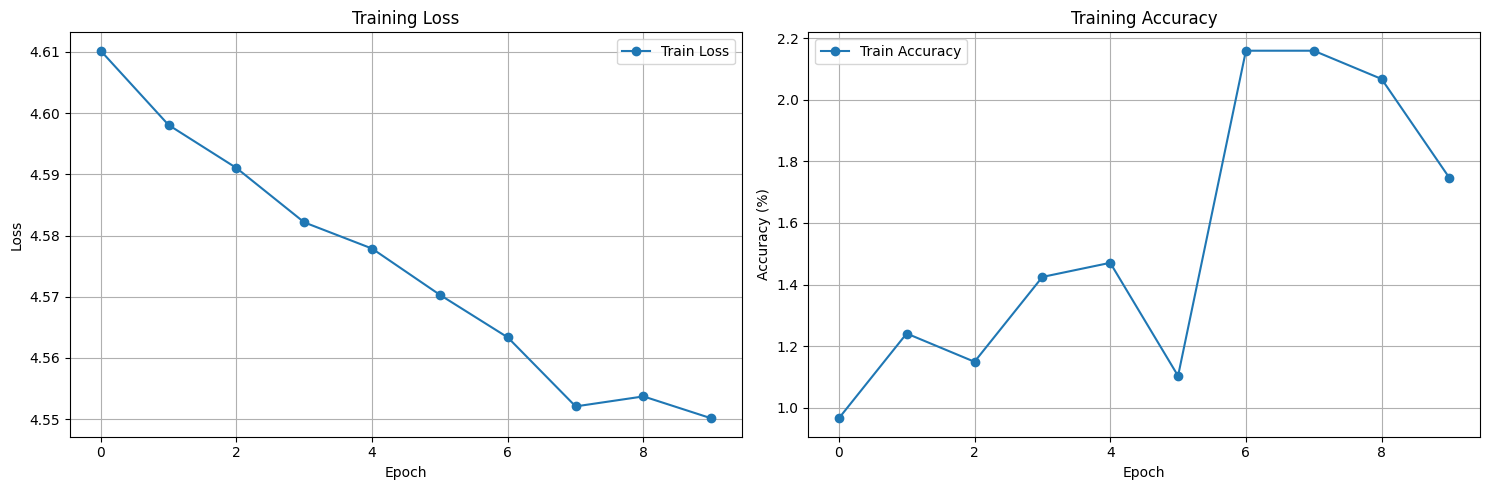

C:\Users\KimieCrafter\AppData\Local\Temp\ipykernel_22488\2826131969.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Spectrum_CNN.pth')


Loading best model for testing...

Performing detailed test evaluation...
Starting detailed test evaluation...


Testing:   0%|          | 0/18 [00:00<?, ?it/s]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1957.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1369.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample782.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2255.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2160.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2140.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample134.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1835.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2681.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample777.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1636.npy: 'label'
Error loading C:/IIUM/AI

Testing:   6%|▌         | 1/18 [00:01<00:19,  1.16s/it]

Sample   1: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   2: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   3: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   4: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   5: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   6: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   7: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   8: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample   9: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  10: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  11: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  12: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  13: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  14: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  15: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  16: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  17: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  18: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  19: True=  0, Pred=  0, Confidence=  2

Testing:  11%|█         | 2/18 [00:02<00:16,  1.04s/it]

Sample  33: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  34: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  35: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  36: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  37: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  38: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  39: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  40: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  41: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  42: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  43: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  44: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  45: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  46: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  47: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  48: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  49: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  50: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  51: True=  0, Pred=  0, Confidence=  2

Testing:  17%|█▋        | 3/18 [00:03<00:15,  1.01s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample551.npy: 'label'
Sample  65: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  66: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  67: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  68: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  69: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  70: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  71: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  72: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  73: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  74: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  75: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  76: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  77: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  78: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  79: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  80: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  81: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  82:

Testing:  22%|██▏       | 4/18 [00:04<00:14,  1.05s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample881.npy: 'label'
Sample  97: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  98: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample  99: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 100: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 101: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 102: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 103: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 104: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 105: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 106: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 107: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 108: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 109: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 110: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 111: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 112: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 113: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 114:

Testing:  28%|██▊       | 5/18 [00:05<00:14,  1.14s/it]

Sample 129: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 130: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 131: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 132: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 133: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 134: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 135: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 136: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 137: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 138: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 139: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 140: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 141: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 142: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 143: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 144: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 145: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 146: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 147: True=  0, Pred=  0, Confidence=  2

Testing:  33%|███▎      | 6/18 [00:06<00:13,  1.12s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2393.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2687.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample503.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1550.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample824.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1027.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample987.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2531.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample696.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample66.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample131.npy: 'label'
Error loading C:/IIUM/AI Not

Testing:  39%|███▉      | 7/18 [00:07<00:11,  1.05s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2120.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample353.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1355.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2571.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample170.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1135.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2385.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1288.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample239.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1671.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1121.npy: 'label'
Error loading C:/IIUM/AI

Testing:  44%|████▍     | 8/18 [00:08<00:09,  1.01it/s]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2058.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1852.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1417.npy: 'label'
Sample 225: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 226: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 227: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 228: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 229: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 230: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 231: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 232: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 233: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 234: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 235: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 236: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 237: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 238: True=  0, Pred=  0, Confidence= 

Testing:  50%|█████     | 9/18 [00:09<00:08,  1.02it/s]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2406.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample228.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2386.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2093.npy: 'label'
Sample 257: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 258: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 259: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 260: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 261: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 262: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 263: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 264: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 265: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 266: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 267: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 268: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 26

Testing:  56%|█████▌    | 10/18 [00:10<00:08,  1.03s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample315.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample283.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample692.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample282.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample837.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2201.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2119.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample354.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2229.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample137.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1706.npy: 'label'
Error loading C:/IIUM/AI Not

Testing:  61%|██████    | 11/18 [00:11<00:07,  1.04s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1709.npy: 'label'
Sample 321: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 322: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 323: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 324: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 325: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 326: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 327: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 328: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 329: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 330: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 331: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 332: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 333: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 334: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 335: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 336: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 337: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 338

Testing:  67%|██████▋   | 12/18 [00:12<00:06,  1.06s/it]

Sample 353: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 354: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 355: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 356: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 357: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 358: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 359: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 360: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 361: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 362: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 363: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 364: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 365: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 366: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 367: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 368: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 369: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 370: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 371: True=  0, Pred=  0, Confidence=  2

Testing:  72%|███████▏  | 13/18 [00:13<00:05,  1.09s/it]

Sample 385: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 386: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 387: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 388: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 389: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 390: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 391: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 392: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 393: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 394: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 395: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 396: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 397: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 398: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 399: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 400: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 401: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 402: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 403: True=  0, Pred=  0, Confidence=  2

Testing:  78%|███████▊  | 14/18 [00:14<00:04,  1.07s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1061.npy: 'label'
Sample 417: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 418: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 419: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 420: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 421: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 422: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 423: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 424: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 425: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 426: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 427: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 428: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 429: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 430: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 431: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 432: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 433: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 434

Testing:  83%|████████▎ | 15/18 [00:15<00:03,  1.04s/it]

Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1491.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample430.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample623.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1789.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2205.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample451.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1673.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2387.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample2130.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample1393.npy: 'label'
Error loading C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot/sample499.npy: 'label'
Error loading C:/IIUM/AI 

Testing:  89%|████████▉ | 16/18 [00:16<00:02,  1.02s/it]

Sample 481: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 482: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 483: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 484: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 485: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 486: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 487: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 488: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 489: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 490: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 491: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 492: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 493: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 494: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 495: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 496: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 497: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 498: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 499: True=  0, Pred=  0, Confidence=  2

Testing: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]

Sample 513: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 514: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 515: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 516: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 517: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 518: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 519: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 520: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 521: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 522: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 523: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 524: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 525: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 526: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 527: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 528: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 529: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 530: True=  0, Pred=  0, Confidence=  2.3%, ✓
Sample 531: True=  0, Pred=  0, Confidence=  2


c:\IIUM\AI Note IIUM\venv\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


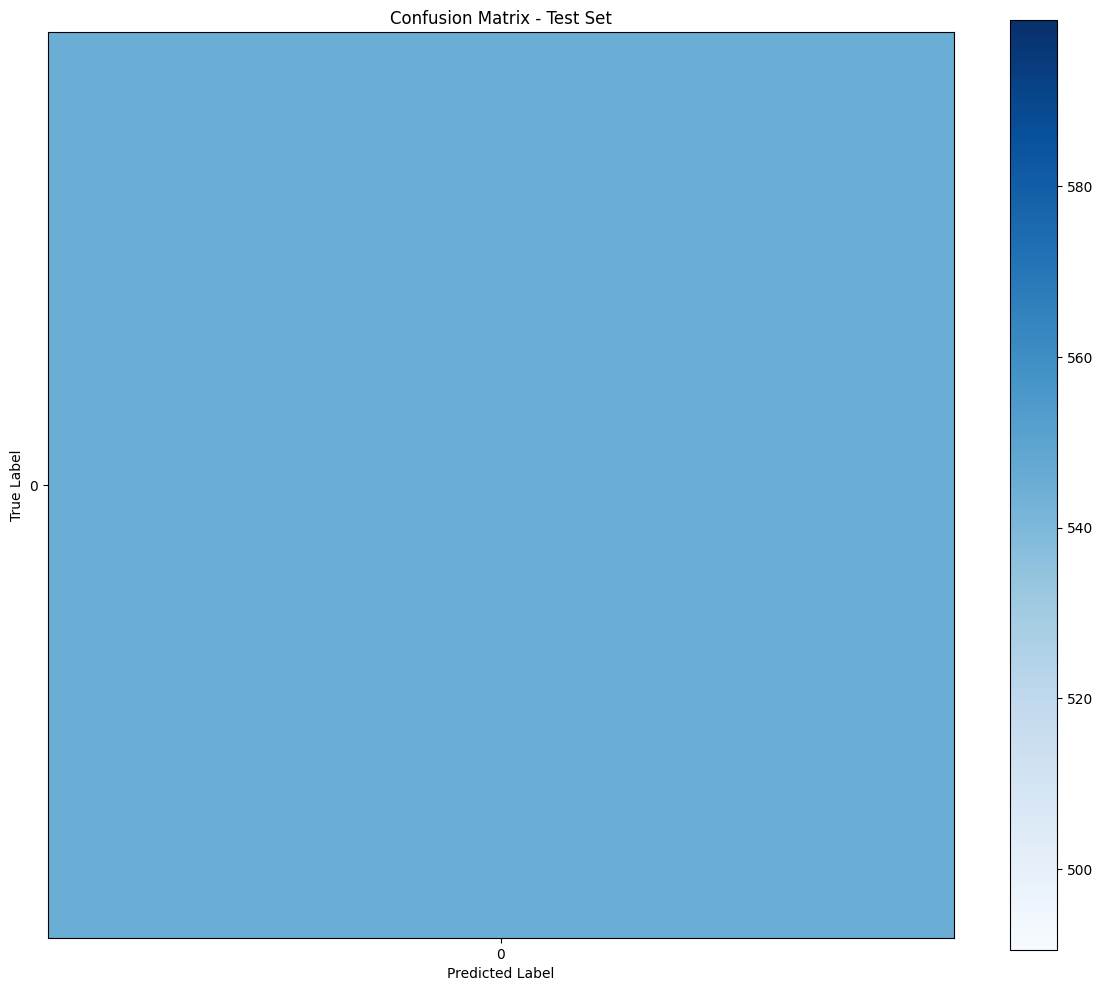


Prediction Summary by Class:
----------------------------------------
Class   0: 545/545 correct (100.0%)


In [36]:
# Use full train_df for training (no validation split)
train_dataset = HyperspectralDataset(train_df, base_path, augment=True)

# Create test dataset (assuming you have test_df with labels 1-100)
test_dataset = HyperspectralDataset(test_df, base_path, augment=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize model, criterion, and optimizer
model = HyperspectralCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Train the model
print("\nStarting training...")
model = train_model(model, train_loader, EPOCHS, criterion, optimizer)

# Load the best model
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('Spectrum_CNN.pth'))

# Perform detailed testing
print("\nPerforming detailed test evaluation...")
test_loss, test_preds, test_labels, test_probabilities = detailed_test_evaluation(
    model, test_loader, criterion
)